# Steady two-dimensional flow to wells in uniform background flow

The Python code provided below is derived from Chapter 7 edited by Christina Norton <br>
**Analytical Groundwater Modeling: Theory and Applications Using Python** <br>
by *Mark Bakker and Vincent Post* <br>
ISBN 9781138029392   <br>
The book is published by CRC press and is available [here](https://www.routledge.com/Analytical-Groundwater-Modeling-Theory-and-Applications-using-Python/Bakker-Post/p/book/9781138029392).  <br>
This Notebook is provided under the [MIT license](https://github.com/pythongroundwaterbook/analytic_gw_book/blob/main/LICENSE). <br>
© 2022 Mark Bakker and Vincent Post

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 3) # set default figure size
plt.rcParams["contour.negative_linestyle"] = 'solid' # set default line style
plt.rcParams["figure.autolayout"] = True # same at tight_layout after every plot

## A single well in uniform background flow

In [38]:
# parameters
xw = 0 # x-location of well, m
yw = 0 # y-location of well, m
Q = 80 # discharge of well, m^3/d
Qi = -40 # injection to well, m^3/d
U = 0.5 # uniform flow in x-direction, m^2/d

In [39]:
# solution for pumping well
xs = xw + Q / (2 * np.pi * U)
xg, yg = np.meshgrid(np.linspace(-200, 100, 100), np.linspace(-100, 100, 100))
psi = Q / (2 * np.pi) * np.arctan2(yg, xg) - U * yg

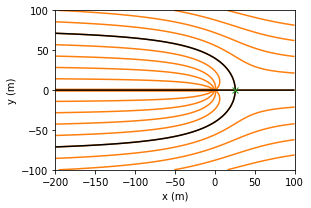

In [40]:
# basic streamline plot, left graph
plt.subplot(111, aspect=1)
plt.contour(xg, yg, psi, 10, colors='C1', linestyles='-')
plt.contour(xg, yg, psi, [-U * yw], colors='k', linestyles='-') # envelope
plt.plot(xs, 0, 'C2x'); # stagnation point
plt.xlabel('x (m)')
plt.ylabel('y (m)');

In [41]:
# solution for injection well
xs = xw + Qi / (2 * np.pi * U)
xg, yg = np.meshgrid(np.linspace(-200, 100, 100), np.linspace(-100, 100, 100))
psi = Qi / (2 * np.pi) * np.arctan2(yg, xg) - U * yg

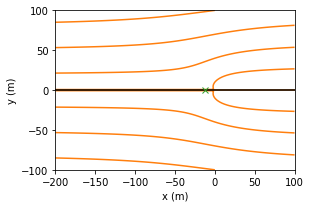

In [42]:
# basic streamline plot, left graph
plt.subplot(111, aspect=1)
plt.contour(xg, yg, psi, 10, colors='C1', linestyles='-')
plt.contour(xg, yg, psi, [-U * yw], colors='k', linestyles='-') # envelope
plt.plot(xs, 0, 'C2x'); # stagnation point
plt.xlabel('x (m)')
plt.ylabel('y (m)');

In [43]:
# additional parameters
n = 0.3 # porosity, -
H = 20 # aquifer thickenss, m
rw = 0.3 # radius of well, m
tmax = 10 * 365 # total travel time, d
t = np.arange(0, 10 * 365 + 1, 365 / 20) # times pathline is returned, d

In [47]:
# functions
def vxvy(t, xy, xw=0, yw=0):
    x, y = xy
    rsq = (x - xw)**2 + (y - yw)**2
    Qx = U - Q / (2 * np.pi) * (x - xw) / rsq
    Qy = -Q / (2 * np.pi) * (y - yw) / rsq
    return np.array([Qx, Qy]) / (n * H)

def reached_well(t, xy):
    return np.sqrt((xy[0] - xw) ** 2 + (xy[1] - yw) ** 2) - rw

reached_well.terminal = True # specify the terminal attribute

In [53]:
# pathline solution
from scipy.integrate import solve_ivp
path0 = solve_ivp(vxvy, (0, tmax), y0=[-200, 50], t_eval=t, events=reached_well)
print('path0 message:', path0.message)
print(f'path0 reached well after {path0.t_events[0][0] / 365: .2f} years')
print(f'path0 entered well screen at', path0.y_events)
path1 = solve_ivp(vxvy, (0, tmax), y0=[-200, 80], t_eval=t, events=reached_well)
print('path1 message:', path1.message)

path0 message: A termination event occurred.
path0 reached well after  5.57 years
path0 entered well screen at [array([[0.17611069, 0.24286833]])]
path1 message: The solver successfully reached the end of the integration interval.


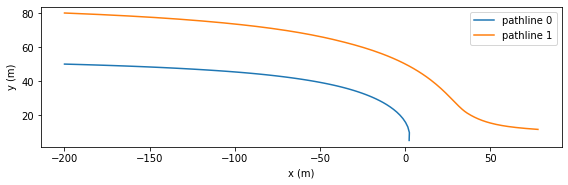

In [54]:
# basic plot
plt.subplot(111, aspect=1)
plt.plot(path0.y[0], path0.y[1], label='pathline 0')
plt.plot(path1.y[0], path1.y[1], label='pathline 1')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend();

## Well capture zones

In [100]:
# parameters
n = 0.25 # porosity, -
k = 20 # hydraulic conductivity, m/d
H = 15 # aquifer thickness, m
dhdx = -0.002 # gradient, -
U = -k * H * dhdx # uniform flow, m^2/d
Q = 500 # discharge of the well, m^3/d
rw = 0.2 # radius of well, m

In [101]:
# solution pumping
# coordinates of capture zone envelope
theta = np.linspace(-3, -1e-4, 100) # bottom half of envelope
r = Q / (2 * np.pi) * theta / (U * np.sin(theta))
xcap = r * np.cos(theta)
ycap = r * np.sin(theta)
# grid inside the capture zone envelope
xg = xcap * np.ones((50, len(xcap)))
yg = np.zeros_like(xg)
for i in range(len(xcap)):
    yg[:, i] = np.linspace(ycap[i] + 1e-3, -ycap[i] - 1e-3, 50)
# travel time for all grid points inside capture zone envelope
theta = np.arctan2(yg, xg)
tgrid = -n * H * xg / U - Q * n * H / (2 * np.pi * U ** 2) * np.log(
        np.sin(theta - 2 * np.pi * U * yg / Q) / np.sin(theta))

Zone of influence plotted for 1 , 5 , 10 years


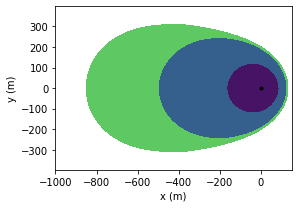

In [116]:
# basic capture zone plot
plt.subplot(111, aspect=1, xlim=(-1000, 150))
plt.plot(0, 0, 'k.')
yr1=1
yr5=5
yr10=10
plt.contourf(xg, yg, tgrid, [0, yr1 * 362.25, yr5 * 365.25, yr10 * 365.25])
plt.xlabel('x (m)')
plt.ylabel('y (m)');
print('Zone of influence plotted for', yr1,',', yr5,',', yr10, 'years')

In [103]:
def vxvy(t, xy, xw=0, yw=0):
    x, y = xy
    rsq = (x - xw)**2 + (y - yw)**2
    Qx = U - Q / (2 * np.pi) * (x - xw) / rsq
    Qy = -Q / (2 * np.pi) * (y - yw) / rsq
    return np.array([Qx, Qy]) / (n * H)

def minvxvy(t, xy): # function vxvy from Section 7.1
    return -vxvy(t, xy, xw=xw0, yw=yw0) - vxvy(t, xy, xw=xw1, yw=yw1)


In [113]:
# additional parameters
xw0, yw0 = 0, 0 # x,y-location well 0, m
xw1, yw1 = -300, 300 # x,y-location well 1, m

Zone of influence plotted for 1 year. Well distance = 300 meters


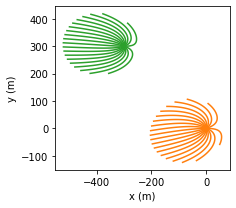

In [119]:
# solution 1 and plot

from scipy.integrate import solve_ivp
xstart = rw * np.cos(np.arange(0, 2 * np.pi, np.pi / 10)) # spaced around well
ystart = rw * np.sin(np.arange(0, 2 * np.pi, np.pi / 10)) # spaced around well
plt.subplot(111, aspect=1)
for i in range(len(xstart)):
    path = solve_ivp(minvxvy, (0, yr1 * 365), [xstart[i] + xw0, ystart[i] + yw0], 
                     t_eval=np.linspace(0,yr1 * 365, 100))
    plt.plot(path.y[0], path.y[1], 'C1')
    path = solve_ivp(minvxvy, (0, yr1 * 365), [xstart[i] + xw1, ystart[i] + yw1], 
                     t_eval=np.linspace(0, yr1 * 365, 100))
    plt.plot(path.y[0], path.y[1], 'C2')
plt.xlabel('x (m)')
plt.ylabel('y (m)');
print('Zone of influence plotted for', yr1,'year. Well distance =', yw1,'meters')



Zone of influence plotted for 5 year. Well distance = 300 meters


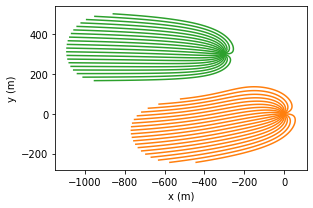

In [120]:
yr=yr5
plt.subplot(111, aspect=1)
for i in range(len(xstart)):
    path = solve_ivp(minvxvy, (0, yr * 365), [xstart[i] + xw0, ystart[i] + yw0], 
                     t_eval=np.linspace(0,yr * 365, 100))
    plt.plot(path.y[0], path.y[1], 'C1')
    path = solve_ivp(minvxvy, (0, yr * 365), [xstart[i] + xw1, ystart[i] + yw1], 
                     t_eval=np.linspace(0, yr * 365, 100))
    plt.plot(path.y[0], path.y[1], 'C2')
plt.xlabel('x (m)')
plt.ylabel('y (m)');
print('Zone of influence plotted for', yr,'year. Well distance =', yw1,'meters')

In [123]:
# additional parameters
xw0, yw0 = 0, 0 # x,y-location well 0, m
xw1, yw1 = 100, 100 # x,y-location well 1, m

Zone of influence plotted for 1 year. Well distance = 100 meters


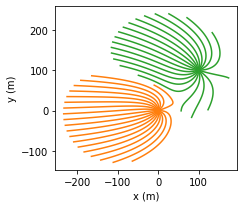

In [124]:
# solution 2 and plot

from scipy.integrate import solve_ivp
xstart = rw * np.cos(np.arange(0, 2 * np.pi, np.pi / 10)) # spaced around well
ystart = rw * np.sin(np.arange(0, 2 * np.pi, np.pi / 10)) # spaced around well

yr=yr1
plt.subplot(111, aspect=1)
for i in range(len(xstart)):
    path = solve_ivp(minvxvy, (0, yr * 365), [xstart[i] + xw0, ystart[i] + yw0], 
                     t_eval=np.linspace(0, yr * 365, 100))
    plt.plot(path.y[0], path.y[1], 'C1')
    path = solve_ivp(minvxvy, (0, yr * 365), [xstart[i] + xw1, ystart[i] + yw1], 
                     t_eval=np.linspace(0, yr * 365, 100))
    plt.plot(path.y[0], path.y[1], 'C2')
plt.xlabel('x (m)')
plt.ylabel('y (m)');
print('Zone of influence plotted for', yr,'year. Well distance =', yw1,'meters')

Zone of influence plotted for 5 year. Well distance = 100 meters


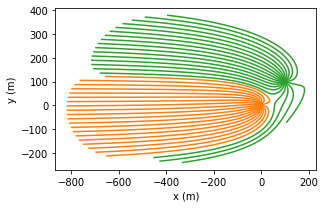

In [125]:
yr=yr5
plt.subplot(111, aspect=1)
for i in range(len(xstart)):
    path = solve_ivp(minvxvy, (0, yr * 365), [xstart[i] + xw0, ystart[i] + yw0], 
                     t_eval=np.linspace(0, yr * 365, 100))
    plt.plot(path.y[0], path.y[1], 'C1')
    path = solve_ivp(minvxvy, (0, yr * 365), [xstart[i] + xw1, ystart[i] + yw1], 
                     t_eval=np.linspace(0, yr * 365, 100))
    plt.plot(path.y[0], path.y[1], 'C2')
plt.xlabel('x (m)')
plt.ylabel('y (m)');
print('Zone of influence plotted for', yr,'year. Well distance =', yw1,'meters')